In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import solve_toeplitz
from statsmodels.tsa.ar_model import AutoReg
from sklearn.linear_model import LinearRegression

order = 3 #Third order TVAR

def load(file):
    """READS THE FILE CONTAINING THE SIGNAL DETAILS_
    I downloaded the original Seisemic signal from the El Centro event. 
    It conisisted of three components NS, EW and UP signifying the surface movement
    in the respective directions as acceleration. 
    
    args: file path which are in txt format chaving two columns 
          time and acceleration
    """
    data = np.loadtxt(file)
    time = data[:, 0]
    signal = data[:, 1] 
    return time, signal

time_ns, signal_ns = load('ns.txt')
time_ew, signal_ew = load('ew.txt')
time_up, signal_up = load('up.txt')


def normalise(signal):
    """
    Normalising the signal to handle abnormally large values.
    """
    return signal / np.max(np.abs(signal))
signal_ns = normalise(signal_ns) #NS component
signal_ew = normalise(signal_ew) #EW component
signal_up = normalise(signal_up) #UP component
signals = np.column_stack((signal_ns, signal_ew, signal_up))

In [35]:
def sliding_window(signal, size, step):
    """We will take the signal and create subsignals from it using the sliding window approach .

    args:
        signal: which is acceleration in our case.
        size: The size of each window.
        step: step or stride represents the amount of overlap between two windows.
    """
    windows = []
    for i in range(0, len(signal) - size, step):
        windows.append(signal[i:i + size])
    return np.array(windows)

size = 50  
step = 10
windows_ns = sliding_window(signal_ns, size, step)
windows_ew = sliding_window(signal_ew, size, step)
windows_up = sliding_window(signal_up, size, step)
print(windows_ns.shape)

(262, 50)


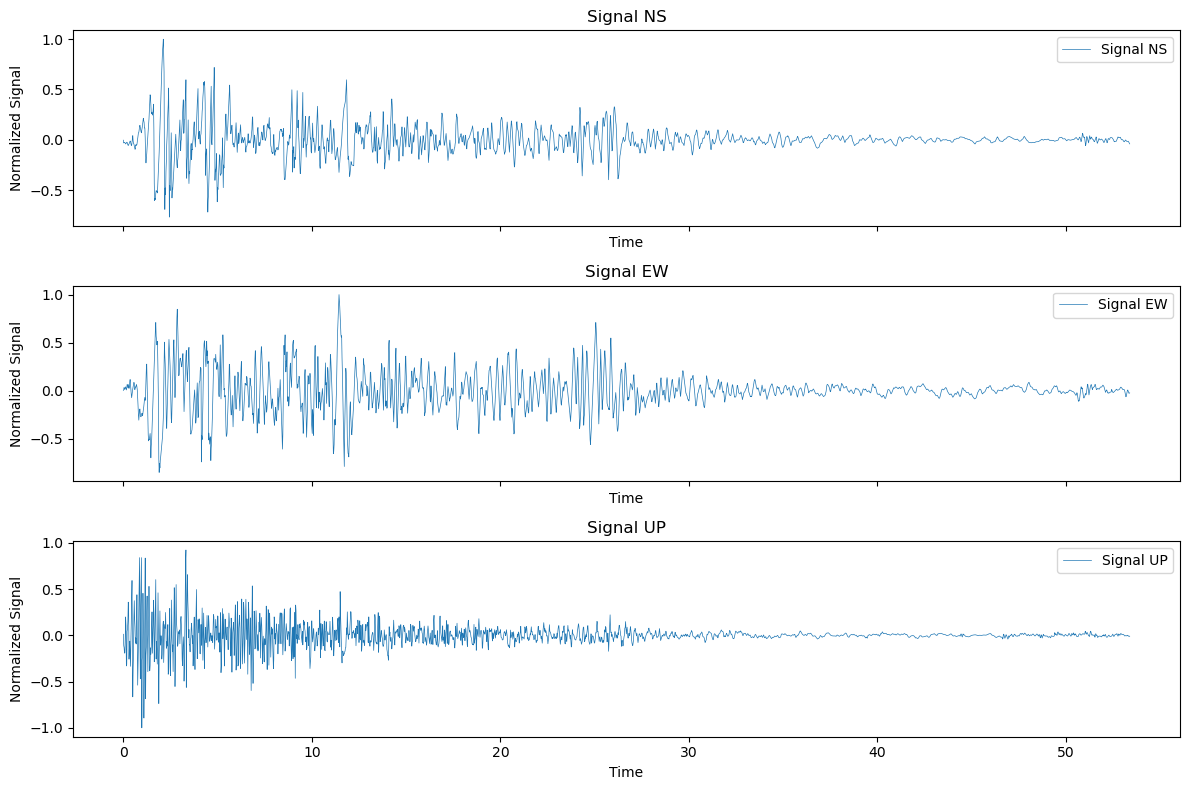

In [36]:
def plot_signal(time, signal, title, ax):
    ax.plot(time, signal, label=title,  linewidth=0.5)
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Normalized Signal')
    ax.legend()

fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
plot_signal(time_ns, signal_ns, 'Signal NS', axs[0])
plot_signal(time_ew, signal_ew, 'Signal EW', axs[1])
plot_signal(time_up, signal_up, 'Signal UP', axs[2])
plt.tight_layout()
plt.show()


In [37]:
def autoregressive_method(window, order):
    """After some research I found out that there exists a pre built function to find the 
    AR coefficients in StatsModels library so I used it as a reference to compare the 
    estimated coefficients which I have discussed later in the code.

    args: Takes the 2D array of windows for each components and the Lags which is the order
    of the TVAR model.
    
    returns a set of 3  coefficients
    """
    model = AutoReg(window, lags=order)
    model_fitted = model.fit() 
    ar_coeffs = model_fitted.params[1:]
    return ar_coeffs

ar_coeffs_ar_ns = np.flip(np.array([autoregressive_method(window_ns, order) for window_ns in windows_ns]),axis=0)
ar_coeffs_ar_ew = np.flip(np.array([autoregressive_method(window_ew, order) for window_ew in windows_ew]),axis=0)
ar_coeffs_ar_up = np.flip(np.array([autoregressive_method(window_up, order) for window_up in windows_up]),axis=0)

In [ ]:
def autocorrelation_method(window, order):
    """Uses the classical Yule-Walker equations to Estimate AR coefficients
    """
    #calculates the correlation around mean of the window with itself (autocorrelation)
    r = np.correlate(window - window.mean(), window - window.mean(), mode='full') 
    #since r is symmetric array we keep only the positive lag terms.
    r = r[len(r)//2:]
    r /= r[0] #normalising wrt to the variance
    # autocorrelation values at lags from 1 to order
    R = r[1:order+1]
    #function is used to solve the system of linear equations that arise from the Yule-Walker equations
    ar_coeffs = solve_toeplitz((r[:order], r[:order]), R)
    #stimated AR coefficients for the specified order
    return ar_coeffs

ar_coeffs_autocorr_ns = np.flip(np.array([autocorrelation_method(window_ns, order) for window_ns in windows_ns]), axis=0)
ar_coeffs_autocorr_ew= np.flip(np.array([autocorrelation_method(window_ew, order) for window_ew in windows_ew]), axis=0)
ar_coeffs_autocorr_up= np.flip(np.array([autocorrelation_method(window_up, order) for window_up in windows_up]), axis=0)


SyntaxError: invalid syntax. Perhaps you forgot a comma? (2945491008.py, line 18)

In [ ]:
def lr_method(window, order):
    """This function is used to estimate the AR coefficients using linear regression.
    The idea is to fit a linear equation on the set of past values to predict the future
    value and obtain the weights or the AR coefficients for a particular lag.    
    """
    n = len(window)
    """
    creates segments from the window of size = 3 (order)
    each segmnet corresponds to the values of signal at different lags
    stacks these segments to craete the input for our model 
    y = w1x1 + w2x2 + w3x3 + c (we set the c to zero)
    example :
    window = window = [x1, x2, x3, x4, x5, x6]
    X = [
        [x1, x2, x3],  
        [x2, x3, x4], 
        [x3, x4, x5],  
        [x4, x5, x6]  
        ]
    y = [x4, x5, x6] these are the values which are to be predicted from the past values
    """
    X = np.column_stack([window[i:n-order+i] for i in range(order)])
    y = window[order:]
    #set the intercept for the model to zero
    model = LinearRegression(fit_intercept=False)
    model.fit(X, y)
    #contains the estimated coefficients (weights) for each lag.
    ar_coeffs = model.coef_
    return np.flip(ar_coeffs)


ar_coeffs_lr_ns =np.flip(np.array([lr_method(window_ns, order) for window_ns in windows_ns]), axis= 0)
ar_coeffs_lr_ew= np.flip(np.array([lr_method(window_ew, order) for window_ew in windows_ew]), axis =0)
ar_coeffs_lr_up= np.flip(np.array([lr_method(window_up, order) for window_up in windows_up]), axis=0)


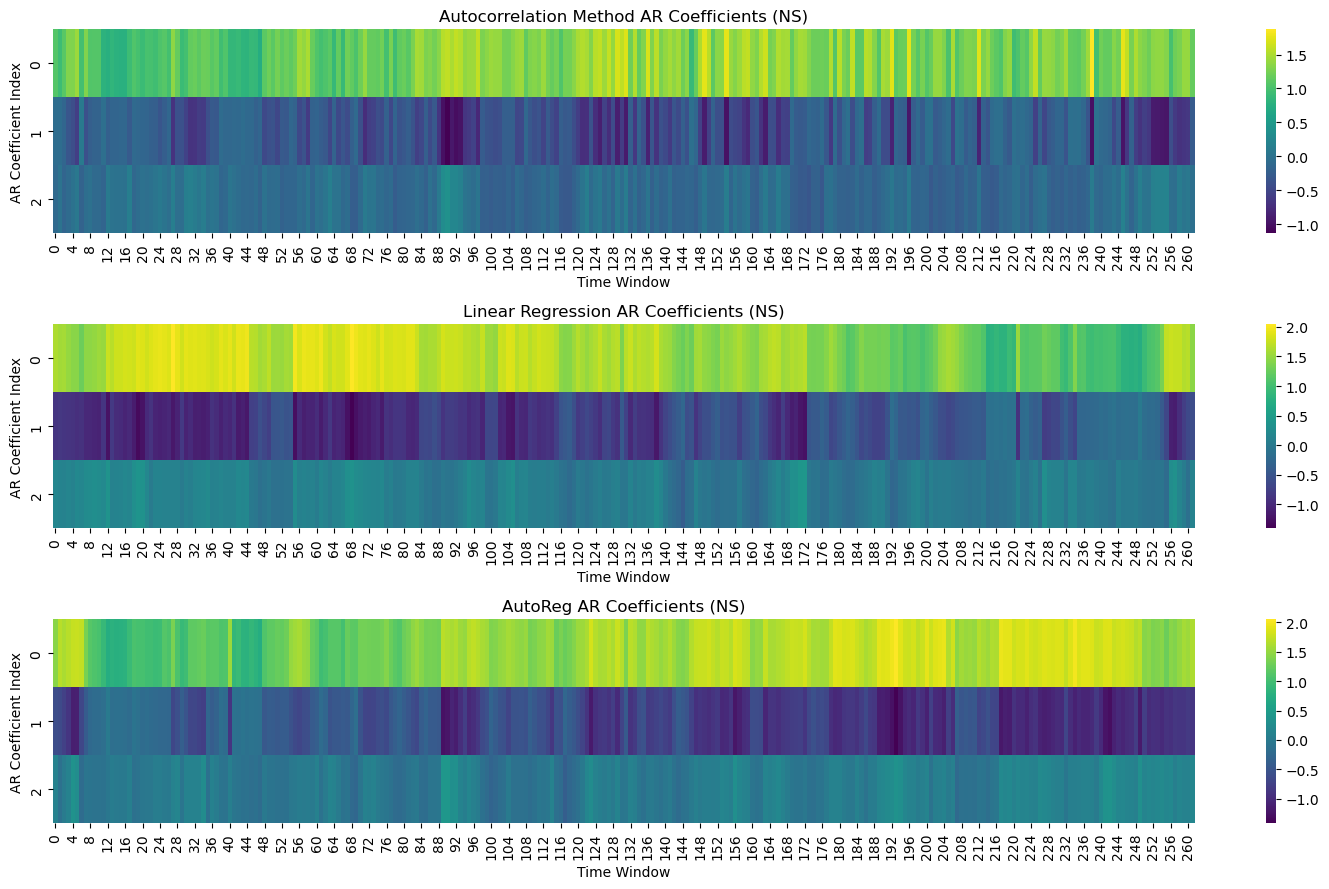

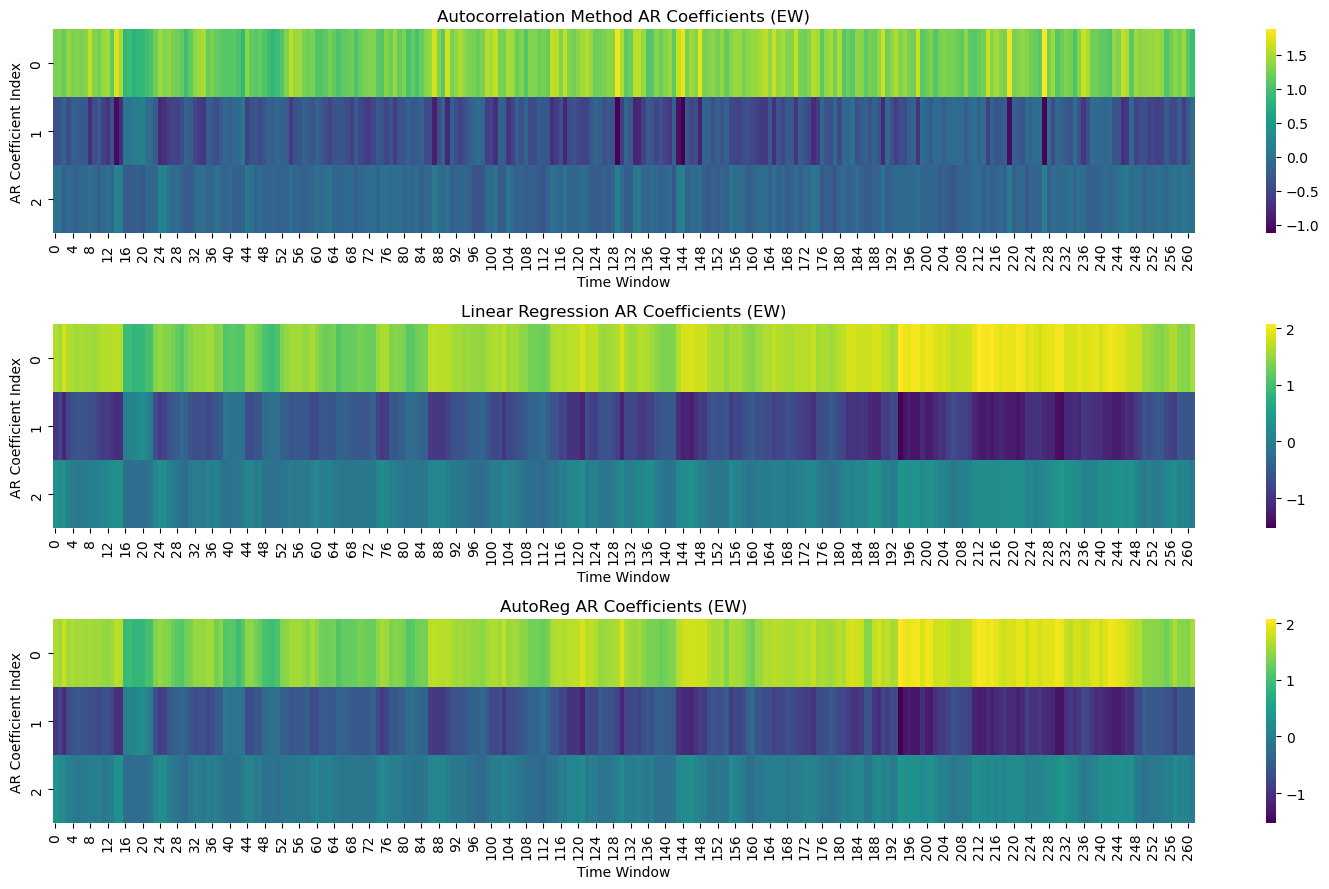

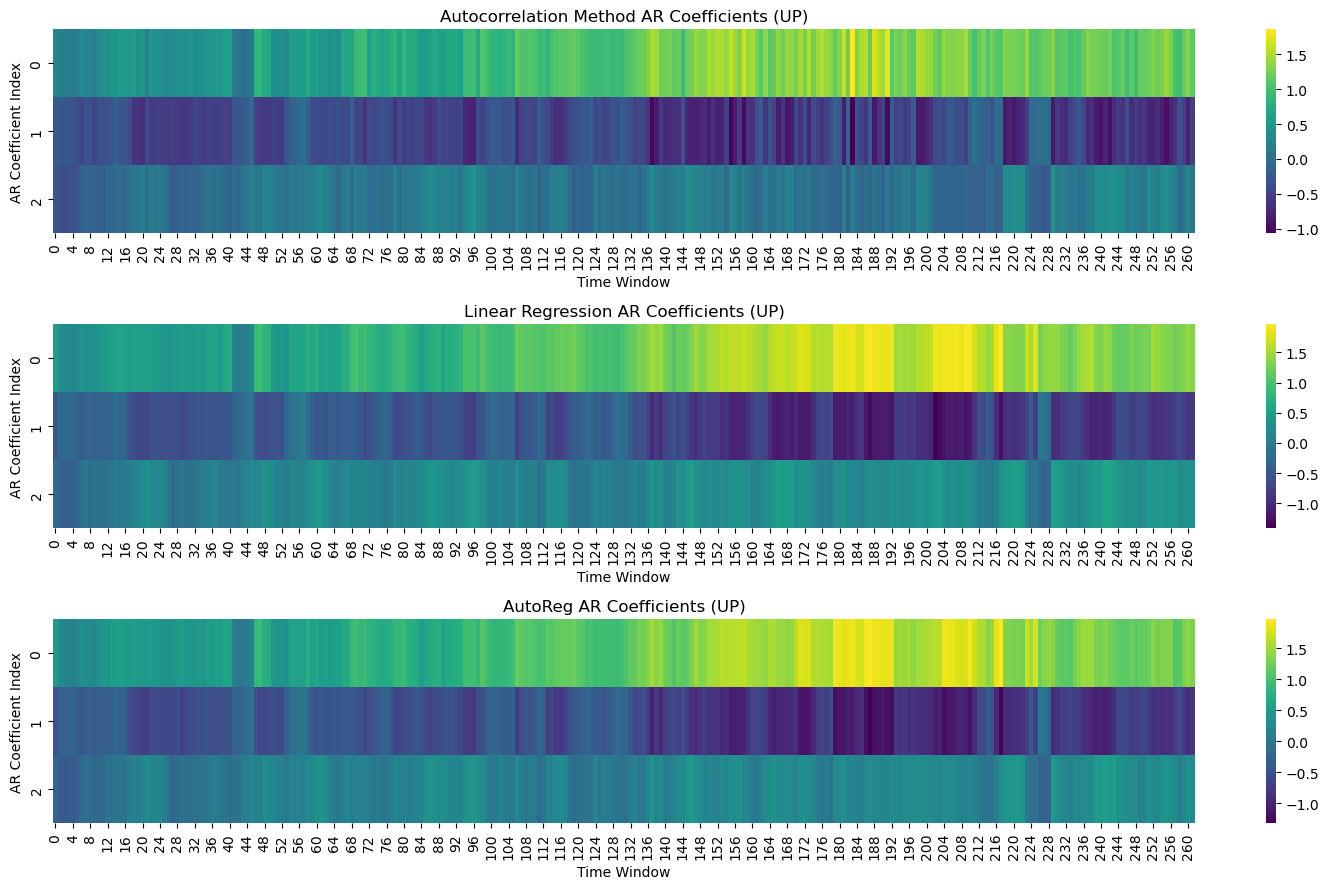

In [ ]:
def plot_comparison_heatmaps(coefficients_autocorr, coefficients_regression, coefficients_ar, title_autocorr, title_regression, title_ar):
    """we will now create the cluster maps for the AR coefficients obtained for the 
    Three signals in NS , EW and UP direction obtained from the three methods namely 
    Auto correlation method : Solving the Yule-Walker equations 
    Linear Regression : Modelling this problem as a linear regression and obtaining
                        the weights associated with each past value.
    statsmodels.tsa.ar_model.AutoReg : A prebuilt function made for this purpose only.
    """
    plt.figure(figsize=(15, 9))
    
    plt.subplot(3, 1, 1)
    sns.heatmap(coefficients_autocorr.T, cmap='viridis', cbar=True, annot=False)
    plt.xlabel('Time Window')
    plt.ylabel('AR Coefficient Index')
    plt.title(title_autocorr)
    
    plt.subplot(3, 1, 2)
    sns.heatmap(coefficients_regression.T, cmap='viridis', cbar=True, annot=False)
    plt.xlabel('Time Window')
    plt.ylabel('AR Coefficient Index')
    plt.title(title_regression)
    
    plt.subplot(3, 1, 3)
    sns.heatmap(coefficients_ar.T, cmap='viridis', cbar=True, annot=False)
    plt.xlabel('Time Window')
    plt.ylabel('AR Coefficient Index')
    plt.title(title_ar)    

    plt.tight_layout()  #to avoid overlap between subplots
    plt.show()

plot_comparison_heatmaps(
    ar_coeffs_autocorr_ns,
    ar_coeffs_lr_ns,
    ar_coeffs_ar_ns,
    "Autocorrelation Method AR Coefficients (NS)",
    "Linear Regression AR Coefficients (NS)",
    "AutoReg AR Coefficients (NS)"
)

plot_comparison_heatmaps(
    ar_coeffs_autocorr_ew,
    ar_coeffs_lr_ew,
    ar_coeffs_ar_ew,
    "Autocorrelation Method AR Coefficients (EW)",
    "Linear Regression AR Coefficients (EW)",
    "AutoReg AR Coefficients (EW)"
)

plot_comparison_heatmaps(
    ar_coeffs_autocorr_up,
    ar_coeffs_lr_up,
    ar_coeffs_ar_up,
    "Autocorrelation Method AR Coefficients (UP)",
    "Linear Regression AR Coefficients (UP)",
    "AutoReg AR Coefficients (UP)"
)
